In [2]:
import numpy as np
import nltk
import pandas as pd

## Word embeddings

Word embeddings are dense representations of words in low-dimensional vector spaces.


In [ ]:
boy = [0.2, -0.1, 0.4, 0.5]
mouse = [-1, 2, 0.2, 1]

### Word2Vec

The TD-IDF model views a document as a bag of words and discards semantic information. It just counts the presence of words in documents.

Word2Vec consists of two algorithms for learning word embeddings.

The CBOW model is a single hidden layer neural network that tries to predict a word given its neighbours. The neighbourhood
of a target word is defined as a window of length $c$: meaning $c$ neighbours before it and $c$ neighbours after it. The Skip-Gram model tries to predict the neighbourhood from the target word.

Let us consider the following sentence:

1. _**it** is our_ Harry that show what we truly are
2. _it **is** our Harry_ that show what we truly are
3. _it is **our** Harry that_ show what we truly are
4. it is our **Harry** that show what we truly are
5. it is our Harry **that** show what we truly are
6. it is our Harry **that** show what we truly are
7. it is our Harry that **show** what we truly are
8. it is our Harry that show **what** we truly are
9. it is our Harry that show what **we** truly are
10. it is our Harry that show what we **truly** are
11. it is our Harry that show what we truly **are**

![Word2Vec model diagrams](https://www.researchgate.net/profile/Elena-Tutubalina/publication/318507923/figure/fig2/AS:613947946319904@1523388005889/Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33.png)

For details refer to [https://arxiv.org/abs/1411.2738v4](https://arxiv.org/abs/1411.2738v4) and to the original [article](https://arxiv.org/abs/1301.3781).

## Data encoding

The starting step to training both CBOW and Skip-Gram is the encoding of the data. All unique words (the vocabulary)
are mapped to one-hot encoded vectors. Let the size (number of words) of the vocabulary be $V$ and let $x$ be the
$V \times 1$ vector encoding the target word in some context of size $C$. Let the size of the hidden layer be $n$.

## Skip-Gram model

The Skip-Gram model predicts the context words of the target by going through the following steps:

It maps the target word vector $x$ to the hidden layer by means of a $V \times n$ matrix $W$.

$$
h = x^{T}W
$$

The hidden layer is thus $1 \ times n$. The hidden layer is mapped to the output layer by means of a second matrix of
weights W^{`} of dimension $n \times V$.

$$
u = W^{`T}h
$$

The predictions of the model are obtained by applying the softmax function to the output layer.

$$
P(w_{c,j} = w_{obs, c}|w_c) = y_{c,j} = \frac{e^{u_{c,j}}}{\sum_{j^` = 1}^{V} e^{u_{j^`}}
$$

The loss function is the negative log-likelihood of observing the _actual_ words in the context given the target word.

$$
L = -\log P(w_{Obs, 1}, w_{Obs, 2}, \ldots, w_{Obs, c}|w_{I}) = \\
-\sum_{c = 1}^{C} u_{j^*_{c}} + C \log\left(\sum_{j^{'}=1}^{V}e^{u_{j^'}}\right)
$$

By computing the gradient of the loss function with respect to the weights we can obtain the
update equations for the gradient descent algorithm. It can be shown, that the update equations
are:

1. For the hidden layer to the output layer

$$
    w^{'\quad (new)}_{ij} = w^{'\quad (old)} - \eta \text{EI}_{j} \cdot h_i\\
$$

where

$$
    EI_{j} = \sum_{c = 1}^{C} e_{c,j}
$$

is the sum of prediction errors at index $j$ over all context words.

2. For the hidden layer -> input layer the weights update equations is
$$
    v_{w_I}^{(new)} = v_{w_I}^{(old)} - \eta \cdot EH^T
$$

where

$$
    EH_i = \sum_{j = 1} ^{V} EI_j \cdot w^{'}_{ij}
$$


## Learning Word2Vec embeddings



In [1]:
# https://gist.github.com/lvngd/3695aac64461de2cfb9d50bb11d5fbb3
import os
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


def tokenize_text(text):
    stemmer = PorterStemmer()
    punct_table = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))

    normalized_sentences = []
    text = re.sub(r'\s+', ' ', text)
    # text = unidecode.unidecode(text)
    text = text.lower()
    # expanded_contractions = list(expand_texts([text], precise=True))
    # if expanded_contractions:
    #     text = expanded_contractions[0]
    sentences = sent_tokenize(text)
    for sentence in sentences:
        # remove punctuation
        sentence = sentence.translate(punct_table)
        # strip leading/trailing whitespace
        sentence = sentence.strip()
        words = word_tokenize(sentence)
        # lemmatize and remove stopwords
        filtered = [stemmer.stem(word) for word in words if word not in stop_words]
        # new_sentence = ' '.join(filtered)
        normalized_sentences.append(filtered)

    return normalized_sentences


def tokenize_corpus(corpus):
    sentences = []
    for text in corpus:
        sentences.extend(tokenize_text(text))

    return sentences


reviews_df = pd.read_csv(os.path.join(".", "data", "reviews.csv"))
reviews_df.dropna(inplace=True)

reviews_tokenized = tokenize_corpus(reviews_df['Reviews'])
reviews_tokenized = list([review for review in reviews_tokenized if len(review) > 0])

In [2]:
reviews_tokenized[:2]

[['phone', 'need', 'sim', 'card', 'would', 'nice', 'know'],
 ['3', 'month', 'away', 'upgrad', 'stratospher', 'kept', 'crap']]

In [4]:
from gensim.models import word2vec

embedding_size = 100

model = word2vec.Word2Vec(
    reviews_tokenized,
    vector_size=embedding_size,
    window=8,
    min_count=1,
    workers=4,
    epochs=50
)

In [7]:
model.wv['boy']

array([ 1.1754372e+00, -6.8615657e-01, -1.0232530e+00,  1.0957611e-02,
       -2.7228233e-01, -7.1557266e-01,  2.6079187e-01,  9.3962979e-01,
       -2.6190987e-01, -7.7131146e-01,  8.1905717e-01,  2.9272875e-01,
        9.0044290e-02,  1.3711958e+00, -9.5054376e-01,  1.3187205e+00,
        1.2064315e+00, -1.7359100e-01, -8.9119053e-01, -2.1610560e+00,
       -4.2271522e-01,  6.5375167e-01,  4.5723230e-02, -2.7475691e-01,
        6.9127011e-01, -1.8765765e+00,  2.5184321e+00, -7.9945624e-01,
        8.7344402e-01, -5.3740460e-01, -8.1254601e-01,  7.2023350e-01,
        1.1115493e+00, -5.6541804e-02,  5.4255742e-01,  8.7765366e-02,
        1.7257698e-01, -3.0703026e-01, -2.2552586e-01, -4.2221732e+00,
        3.4289885e-01,  1.2889907e+00, -7.8703517e-01, -4.6245456e-01,
        1.5020660e+00, -2.7281296e-01, -1.3273212e+00,  8.4772074e-01,
        7.0051086e-01, -4.3231386e-01,  6.3954645e-01,  1.2685471e+00,
       -2.1572100e-01,  3.2341859e-01,  6.4797884e-01, -2.2969987e+00,
      

In [8]:
model.wv['girl']

array([-3.5356402e-01, -8.7655194e-02, -1.1258432e+00, -6.8501270e-01,
       -2.1255270e-02,  5.8243632e-01, -8.1269205e-01,  2.8084379e-01,
       -2.1284640e+00, -2.0709626e-01,  2.4799906e-01,  8.9672548e-01,
       -2.4082531e-01,  1.0032799e+00, -1.1892920e+00,  1.3707592e-01,
       -5.3756422e-01,  1.2302785e+00, -3.6895880e-01, -4.2545943e+00,
       -5.5638713e-01, -9.5835859e-01,  3.3488634e-01, -9.8918104e-01,
       -4.9112543e-01,  2.4109771e+00, -1.5607861e+00, -7.8432256e-01,
        4.5211354e-01,  7.6845330e-01,  1.2492409e+00,  8.8394485e-02,
       -1.4708042e-01,  1.9435315e-01,  2.0073613e-04,  1.4763364e+00,
       -9.7267550e-01, -9.8905581e-01,  4.6910159e-02,  5.9602851e-01,
       -1.2008673e-01, -2.7734786e-01, -9.6203184e-01,  2.1126956e-01,
        1.2205329e+00,  1.1775591e+00,  7.7042603e-01,  1.3306569e+00,
        1.0563660e+00,  7.7089888e-01,  7.3123711e-01,  2.0829086e+00,
        5.9017229e-01,  1.5451493e+00,  2.2089977e+00,  4.1820893e-01,
      

In [10]:
girl_vec = model.wv["girl"]
boy_vec = model.wv["boy"]

np.dot(girl_vec, boy_vec) / (np.linalg.norm(girl_vec) * np.linalg.norm(boy_vec))

0.18851212

The similarity between two words is the cosine similarity defined as

$$
\text{similarity}(w_1, w_2) = \frac{w_{1}\cdot w_{2}}{||w_{1}|| \cdot ||w_{2}||}
$$

it ranges from -1 (perfect dissimilarity) to 1 (perfect closeness).

In [13]:
model.wv.most_similar("girl")

[('girlfriend', 0.550525426864624),
 ('brother', 0.4981984496116638),
 ('gift', 0.4865741729736328),
 ('nephew', 0.48511067032814026),
 ('she', 0.4742458760738373),
 ('screenwhen', 0.4689643681049347),
 ('hubbi', 0.46226418018341064),
 ('fudg', 0.4533400237560272),
 ('boyfriend', 0.43792641162872314),
 ('38mm', 0.4373270869255066)]

In [9]:
model.wv.similarity("problem", "price")

-0.29567584

In [10]:
model.wv.most_similar("hate")

[('like', 0.4485587775707245),
 ('crazi', 0.3970179259777069),
 ('love', 0.3893566131591797),
 ('development', 0.37303221225738525),
 ('drawer', 0.3672596514225006),
 ('suckynow', 0.36245259642601013),
 ('amazin', 0.3502294719219208),
 ('everythingth', 0.343802273273468),
 ('kinda', 0.3371528387069702),
 ('want', 0.33571404218673706)]

/home/amarov/anaconda3/envs/text-analytics-script/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/amarov/anaconda3/envs/text-analytics-script/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


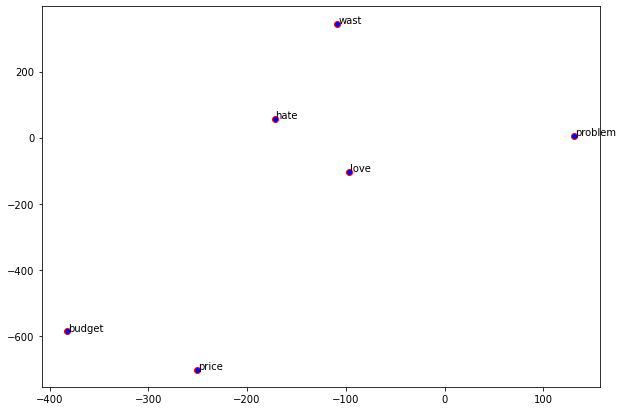

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

## https://ronxin.github.io/wevi/

words = ["love", "price", "budget", "hate", "wast", "problem"]
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)

labels = words
plt.figure(figsize=(10, 7))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points')


In [25]:
## Use the vectors to create average document embeddings

docs_embedding = np.zeros((reviews_df.shape[0], embedding_size), dtype="float64")
doc_idx = 0

for review in reviews_df.Reviews:
    sentences = tokenize_text(review)

    features = np.zeros((embedding_size,), dtype="float64")

    words_cnt = 0
    for sentence in sentences:
        for word in sentence:
            words_cnt += 1
            features = np.add(features, model.wv[word])

    if words_cnt > 0:
        features = np.divide(features, words_cnt)

    docs_embedding[doc_idx] = features
    doc_idx += 1


In [30]:
docs_embedding.shape

(40062, 100)

In [ ]:
docs_embedding[:4,:3]

In [20]:
sample_indices = np.random.randint(10, size=2000)
sample_docs_embedding = docs_embedding[sample_indices]

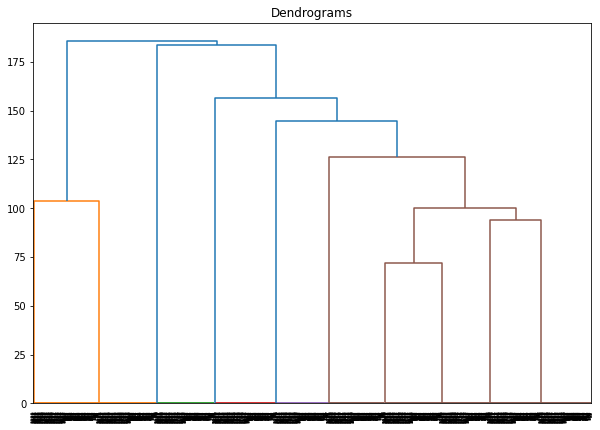

In [23]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(sample_docs_embedding, method='ward'))

In [22]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agglom_pred = cluster.fit_predict(sample_docs_embedding)

### Pre-trained Word2Vec vectors


In [17]:
import gensim.models.keyedvectors as word2vec
import gensim
# model = word2vec.load_word2vec_format("pretrained/GoogleNews-vectors-negative300.bin.gz", binary=True)
import gensim.downloader as gs_api

w2vec_pre = gs_api.load("word2vec-google-news-300")


In [21]:
w2vec_pre.similarity("health", "care")

0.466594

In [23]:
w2vec_pre.similarity("girl", "boy")

0.8543272

In [63]:
w2vec_pre.most_similar(positive=["king", "men"], negative=["women"])


[('kings', 0.6467223763465881),
 ('prince', 0.5280967354774475),
 ('princes', 0.4967823624610901),
 ('crown_prince', 0.49598073959350586),
 ('sultan', 0.4732935428619385),
 ('monarch', 0.4715597629547119),
 ('ruler', 0.466869592666626),
 ('clown_prince', 0.4635189473628998),
 ('undisputed_king', 0.45983585715293884),
 ('King', 0.4503089189529419)]

In [32]:
## Vocabulary size
vocab = model.key_to_index.keys()
print("Vocabulary size is", str(len(vocab)))

Vocabulary size is 3000000


In [33]:
## Similarity between two words

print(model.similarity("car", "vehicle"))

0.7821096
